In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../coral')
sys.path.append('../')

import utils_HCC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import scipy
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset,ConcatDataset
from scipy.stats import zscore

from sklearn.neighbors import KDTree,NearestNeighbors
from coral import coral_main, VisCoxDataset, utils, utils_exp, utils_simu
from scipy.spatial import cKDTree

import scanpy as sc
import anndata
import torch

import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("GPU is available.")
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available.")
    

GPU is available.
Number of GPUs available: 1
GPU 0: NVIDIA A40


In [3]:
codex_folder = '/hpc/mydata/siyu.he/Siyu_projects/HCC_project/codex_raw/'
visium_folder = '/hpc/mydata/siyu.he/Siyu_projects/HCC_project/visium/'

codex_seg_folder = '/hpc/mydata/siyu.he/Siyu_projects/HCC_project/codex_seg/'
trans_loc_folder = '/hpc/mydata/siyu.he/Siyu_projects/HCC_project/transformed_visium_loc'
cell_type_folder = '/hpc/mydata/siyu.he/Siyu_projects/HCC_project/codex_cell_type/'


meta_info =[            
            ['73_3_pre', 'FinalLiv-27_c001_v001_r001_reg014_he_aligned.tif', '073-3.ome.tif','cytassist_73_pre', 'FinalLiv-27_c001_v001_r001_reg014_codex.csv','073_3_tissue_positions_list.csv','FinalLiv-27_c001_v001_r001_reg014.cell_types.csv'],
            ['73_5_post','FinalLiv-27_c001_v001_r001_reg016_he_aligned.tif', '073-5.ome.tif','cytassist_73_post','FinalLiv-27_c001_v001_r001_reg016_codex.csv','073_5_tissue_positions_list.csv','FinalLiv-27_c001_v001_r001_reg016.cell_types.csv'],
            ['84_2_pre', 'FinalLiv-27_c002_v001_r001_reg009_he_aligned.tif', '084-2.ome.tif','cytassist_84_pre', 'FinalLiv-27_c002_v001_r001_reg009_codex.csv','084_2_tissue_positions_list.csv','FinalLiv-27_c002_v001_r001_reg009.cell_types.csv'],
            ['84_3_post','FinalLiv-27_c002_v001_r001_reg010_he_aligned.tif', '084-3.ome.tif','cytassist_84_post','FinalLiv-27_c002_v001_r001_reg010_codex.csv','084_3_tissue_positions_list.csv','FinalLiv-27_c002_v001_r001_reg010.cell_types.csv'],
           ]
meta_info = pd.DataFrame(meta_info, columns=['sample','histo_file','codex_raw_file','visium_file','codex_seg_file','trans_loc_file','cell_type_file'])

cell_type_label_mapping = {'Neutrophils': 0,
 'Macrophages': 1,
 'B cells': 2,
 'CD4 T cells': 3,
 'Stroma Uncharacterized': 4,
 'INFg+': 5,
 'Macrophages M2-like': 6,
 'Fibroblasts': 7,
 'Endothelial cells': 8,
 'Tumor Inos': 9,
 'Tumor': 10,
 'CD8 T cells': 11,
 'Dendritic cells': 12,
 'Unknown': 13}

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: 

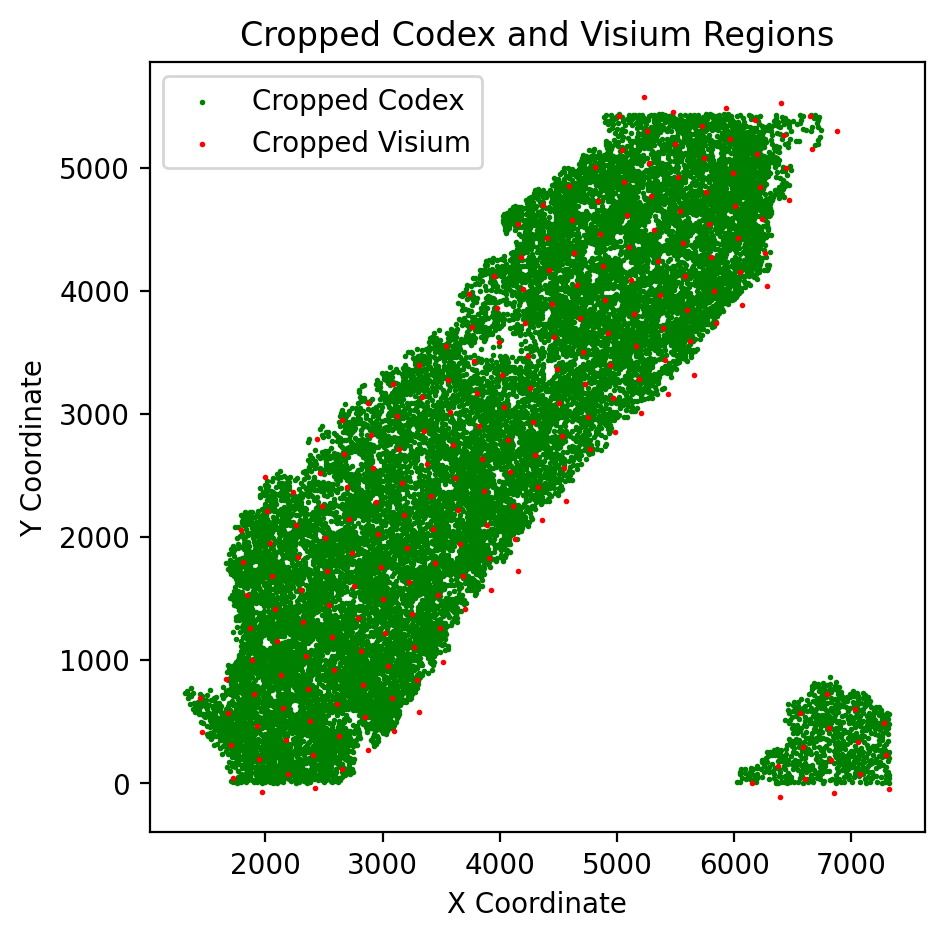

(15910, 51)


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: 

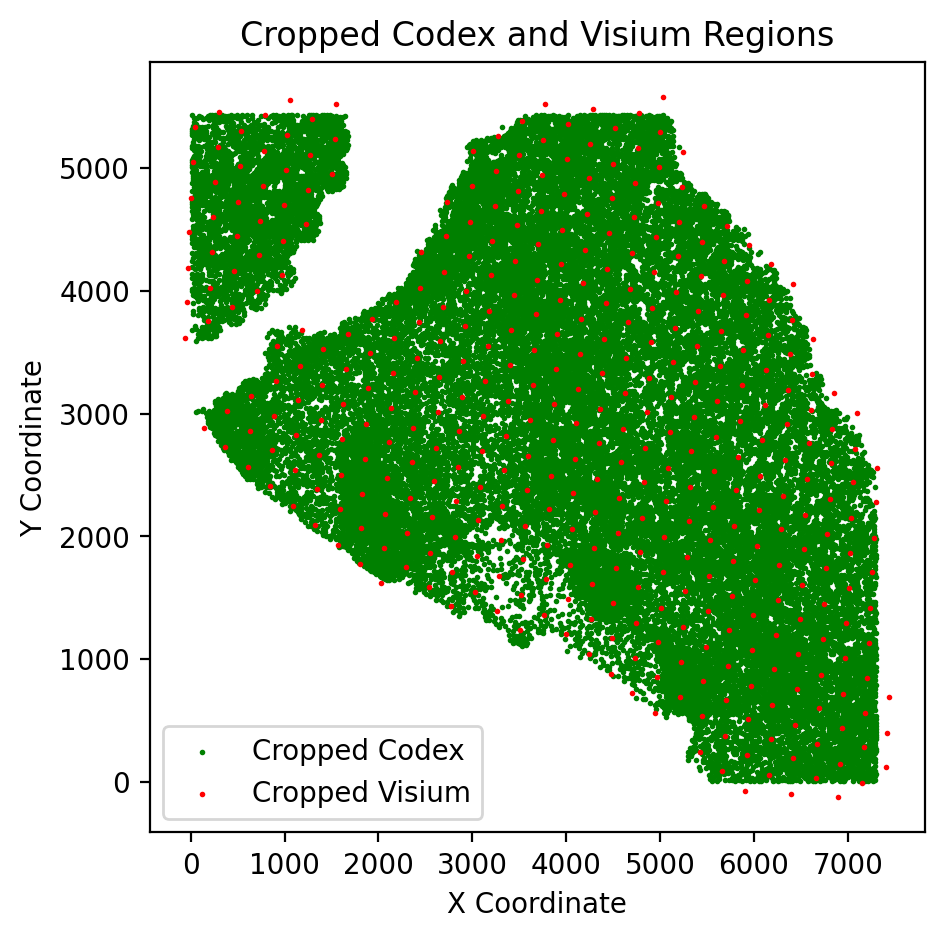

(33860, 51)


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: 

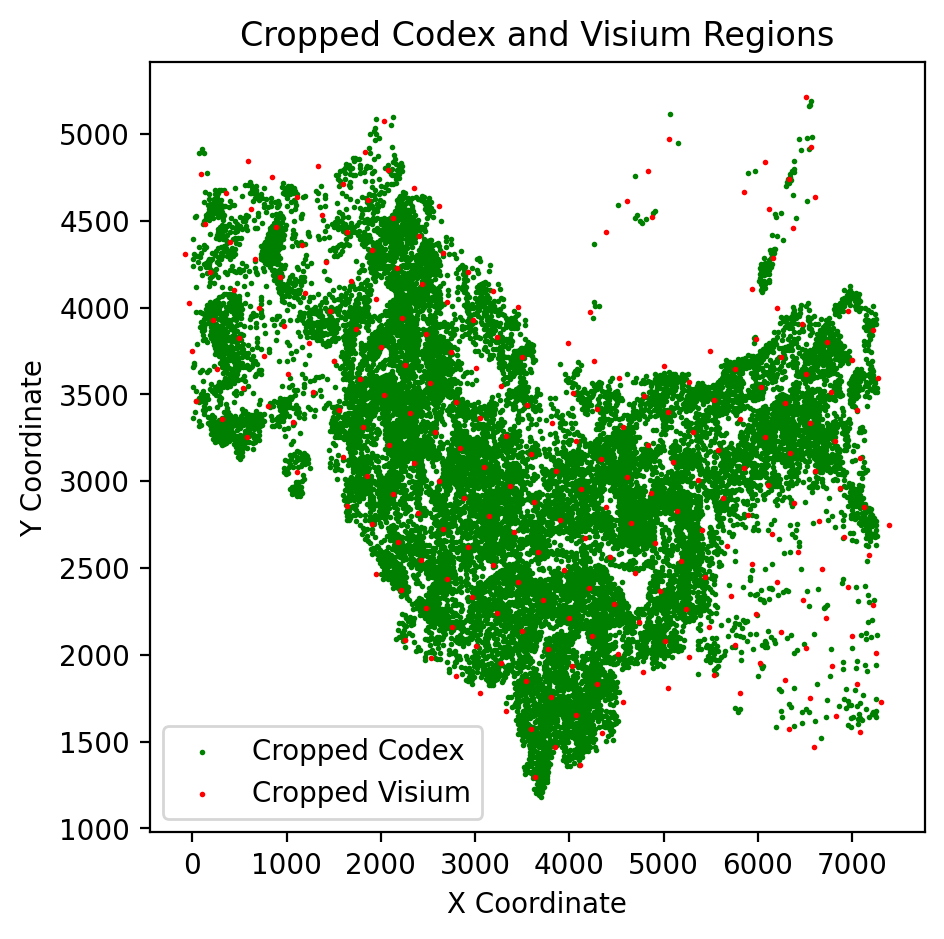

(13341, 51)


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: 

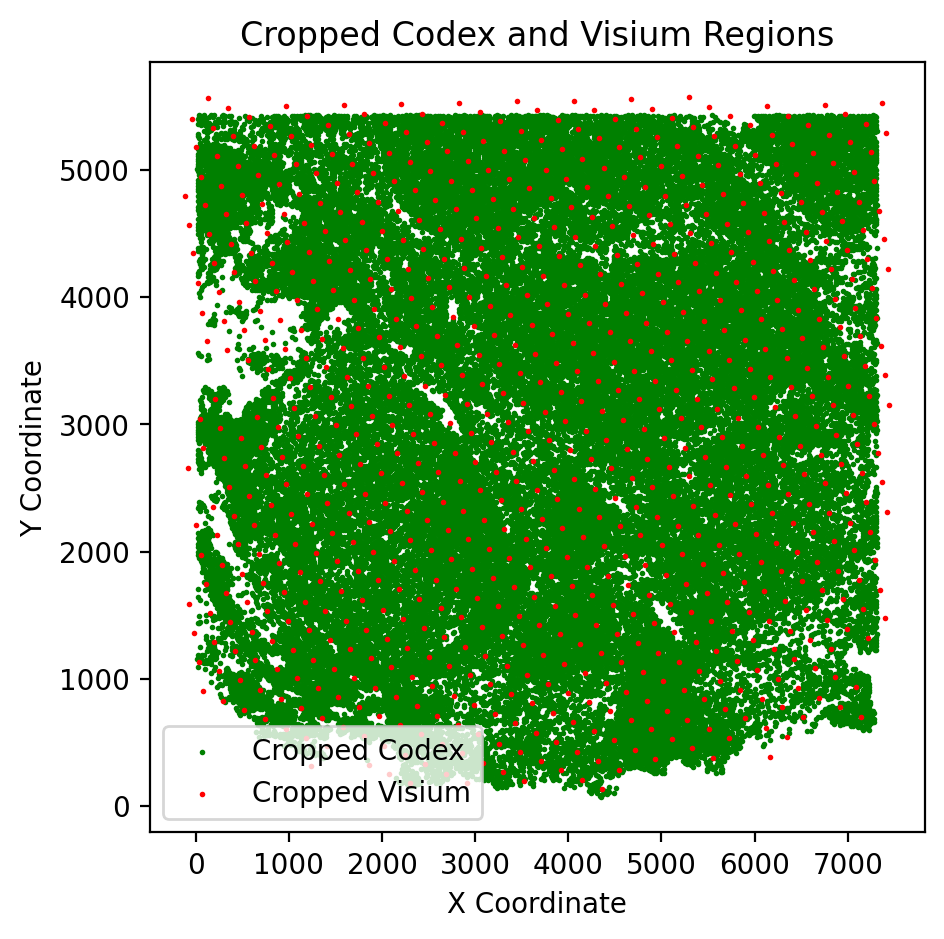

(50519, 51)


In [22]:
visium_adata_all = []
codex_adata_all = []

for i in range(len(meta_info)):

    visium_adata_temp, codex_adata_temp = utils_HCC.load_data(visium_path = os.path.join(visium_folder, meta_info.loc[i,'visium_file']),
                                                    trans_loc = os.path.join(trans_loc_folder, meta_info.loc[i,'trans_loc_file']),
                                                    codex_path = os.path.join(codex_seg_folder, meta_info.loc[i,'codex_seg_file']),
                                                    type_path = os.path.join(cell_type_folder, meta_info.loc[i,'cell_type_file']), 
                                                    cell_type_label_mapping = cell_type_label_mapping,
                                                   

                                         )
    visium_adata_temp.obsm['spatial'] =np.concatenate([visium_adata_temp.obs['transformed coords x'].values[:,None],visium_adata_temp.obs['transformed coords y'].values[:,None]],axis=1)
    codex_adata_temp.obsm['spatial'] =np.concatenate([codex_adata_temp.obs.x.values[:,None],codex_adata_temp.obs.y.values[:,None]],axis=1)
    
    
    overlap_distance_threshold = 150  # Adjust this based on your dataset's spatial scale

    codex_coords = codex_adata_temp.obsm['spatial'] 
    visium_coords = visium_adata_temp.obsm['spatial']

    # Find Codex points near Visium points
    visium_nn = NearestNeighbors(n_neighbors=1).fit(visium_coords)
    distances, _ = visium_nn.kneighbors(codex_coords)
    codex_enlarged_mask = distances[:, 0] < overlap_distance_threshold
    codex_enlarged_coords = codex_coords[codex_enlarged_mask]

    # Find Visium points near Codex points
    codex_nn = NearestNeighbors(n_neighbors=1).fit(codex_coords)
    visium_to_codex_distances, _ = codex_nn.kneighbors(visium_coords)
    visium_cropped_mask = visium_to_codex_distances[:, 0] < overlap_distance_threshold
    visium_cropped_coords = visium_coords[visium_cropped_mask]

    # Crop the AnnData objects based on the masks
    codex_adata_cropped = codex_adata_temp[codex_enlarged_mask, :].copy()
    visium_adata_cropped = visium_adata_temp[visium_cropped_mask, :].copy()

    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

   
    plt.scatter(codex_enlarged_coords[:, 0], codex_enlarged_coords[:, 1], s=1, color='g', label='Cropped Codex')
    plt.scatter(visium_cropped_coords[:, 0], visium_cropped_coords[:, 1], s=1, color='r', label='Cropped Visium')

    plt.legend()
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Cropped Codex and Visium Regions")

    plt.show()
    
    
    codex_adata_cropped.obs['cell_type'] = codex_adata_cropped.obs['CELL_TYPE']
    visium_adata_cropped.X = visium_adata_cropped.X.toarray()
    
    if i ==0:
        x_shift = 0
        y_shift = 0
    if i ==1:
        x_shift = 0
        y_shift = 1e4
    if i ==2:
        x_shift = 1e4
        y_shift = 0
    if i ==3:
        x_shift = 1e4
        y_shift = 1e4
        
    visium_adata_cropped.obsm['spatial'] =np.concatenate([visium_adata_cropped.obs['transformed coords x'].values[:,None]+x_shift,
                                                       visium_adata_cropped.obs['transformed coords y'].values[:,None]+y_shift],
                                                      axis=1)
    codex_adata_cropped.obsm['spatial'] =np.concatenate([codex_adata_cropped.obs.x.values[:,None]+x_shift,
                                                      codex_adata_cropped.obs.y.values[:,None]+y_shift],
                                                     axis=1)
    
      
    visium_adata_all.append(visium_adata_cropped)
    print(codex_adata_cropped.shape)
    codex_adata_all.append(codex_adata_cropped)

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


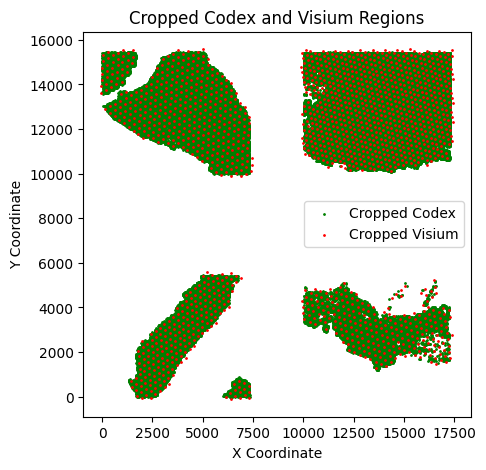

In [5]:
visium_adata_all = sc.concat(visium_adata_all)
codex_adata_all = sc.concat(codex_adata_all)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
plt.scatter(codex_adata_all.obsm['spatial'][:, 0], codex_adata_all.obsm['spatial'][:, 1], s=1, color='g', label='Cropped Codex')
plt.scatter(visium_adata_all.obsm['spatial'][:, 0], visium_adata_all.obsm['spatial'][:, 1], s=1, color='r', label='Cropped Visium')

plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Cropped Codex and Visium Regions")
plt.show()

In [6]:
'CCL7' in visium_adata_all.var_names

True

In [7]:
select_gene = [
    'PDCD1',
    'CD274',
    'CTLA4',
    'FOXP3',
    'AFP',
    'GPC3',
    'VIM',
    'CDH1',
    'TWIST1',
    'ZEB1',
    'ZEB2',
    'VEGFA',
    'HIF1A',
    'GLS',
    'COL1A1',
    'TGFB1',
    'CXCL12',
    'CXCR4',
    'ABCB1',
    'BCL2',
    'IL6',
    'IL1B',
    'TNF',
    'CXCL8',
    'CXCL11',
    'CCL2',
    'CCL3',
    'CCL4',
    'CXCL1',
    'CXCL2',
    'CXCL3',
    'CXCL5',
    'CXCL8',
    'IL18',
    'CCL15',
    'CCL16',
    'IL7R',
    'CXCR4',
    'CCR7',
    'CXCL12',
    'CCL21',
    'CXCL14',
    'IL1A',
    'CXCR2',
    'CCR1',
    'CCL7'
    
]

In [8]:
visium_adata_all  = utils_HCC.preprocess_visium(visium_adata_all, 
                                                used_gene=1000,
                                                select_gene=select_gene
                                               )
codex_adata_all.X = utils_HCC.preprocess_codex(codex_adata_all.to_df())

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
visium_adata_all

View of AnnData object with n_obs × n_vars = 1705 × 1076
    obs: 'barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'transformed coords x', 'transformed coords y'
    obsm: 'spatial'

In [21]:
codex_adata_all

AnnData object with n_obs × n_vars = 113630 × 51
    obs: 'cell_id', 'x', 'y', 'CELL_TYPE', 'cell_type'
    obsm: 'spatial'

In [20]:
codex_adata_all.obs_names

Index(['1', '2', '4', '5', '7', '8', '9', '10', '11', '12',
       ...
       '51066', '51067', '51068', '51069', '51070', '51071', '51072', '51073',
       '51074', '51075'],
      dtype='object', length=113630)

In [11]:
combined_expr, codex_coords, one_hot_cell_types, spot_indices, visium_expr = utils.preprocess_data(visium_adata_all, codex_adata_all)

dataloader = utils.prepare_local_subgraphs(combined_expr, codex_coords, one_hot_cell_types, 
                                           spot_indices, visium_expr,n_neighbors=200)    

model, optimizer = coral_main.create_model(visium_dim = visium_adata_all.shape[1],
                                           codex_dim = codex_adata_all.shape[1],
                                           cell_type_dim=one_hot_cell_types.shape[1],
                                           latent_dim=32, 
                                           hidden_channels=128, 
                                           v_dim = 1
                                          )
model.to(device)

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CORAL_model(
  (encoder_visium): Sequential(
    (0): Linear(in_features=1090, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (encoder_codex): Sequential(
    (0): Linear(in_features=51, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=1141, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (zi_prior): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (cross_attention): CrossAttentionLayer(
    (query_proj): Linear(in_features=32, out_features=32, bias=True)
    (key_proj): Linear(in_features=32, out_features=32, bias=True)
    (value_proj): Linear(in_features=32, out_features=32, bias=True)
    (softmax): Softmax(dim=-1)
  )
  (deconv): Deconvo

In [ ]:
coral_main.train_model(model, optimizer, dataloader, epochs = 100,device = device)

Epoch 0, Loss: 1435334.8314955295
Epoch 1, Loss: 1329351.2762074063
Epoch 2, Loss: 1279645.4558927063
Epoch 3, Loss: 1256412.3836551323
Epoch 4, Loss: 1242194.2876698466
Epoch 5, Loss: 1234739.410179351
Epoch 6, Loss: 1223564.483098951
Epoch 7, Loss: 1217731.9320657912
Epoch 8, Loss: 1225154.383875141
Epoch 9, Loss: 1227444.0301103562
Epoch 10, Loss: 1219629.469995248
Epoch 11, Loss: 1211471.3698606025
Epoch 12, Loss: 1211723.8652536257
Epoch 13, Loss: 1209554.470650873
Epoch 14, Loss: 1210619.7061523162
Epoch 15, Loss: 1204601.2113357154
Epoch 16, Loss: 1201138.6438107223
Epoch 17, Loss: 1201864.4931335363
Epoch 18, Loss: 1196433.8663624683
Epoch 19, Loss: 1195892.6858851379
Epoch 20, Loss: 1191913.906927626
Epoch 21, Loss: 1186723.4609132991
Epoch 22, Loss: 1187253.0411679808
Epoch 23, Loss: 1184806.1974575825
Epoch 24, Loss: 1189066.1665595958
Epoch 25, Loss: 1180232.4168676077
Epoch 26, Loss: 1182833.238255949
Epoch 27, Loss: 1181913.3406390806
Epoch 28, Loss: 1178794.5892090257
Ep

In [12]:
model_save_path = "model_all_1130.pth"
optimizer_save_path = "optimizer_all_1130.pth"


In [ ]:

torch.save(model.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)


In [13]:
 
model.load_state_dict(torch.load(model_save_path))
optimizer.load_state_dict(torch.load(optimizer_save_path))

(generated_expr, 
 generated_protein,latent_rep, 
 locations,
 visium_true,
 codex_true, 
 attn_weights_all, 
 edges_all,
 v_values, 
 cell_types)= coral_main.generate_and_validate(model, dataloader,device) 

adata_model_gener = anndata.AnnData(generated_protein)
adata_model_gener.obsm['generated_expr'] = generated_expr
adata_model_gener.obsm['coral'] = latent_rep
adata_model_gener.obsm['spatial'] = locations
adata_model_gener.obsm['visium_true'] = visium_true
adata_model_gener.obsm['codex_true'] = codex_true
#adata_model_gener.obsm['attn_weights_all'] = attn_weights_all
adata_model_gener.obsm['v_values'] = v_values
adata_model_gener.obsm['cell_types'] = cell_types


In [19]:
attn_weights_all.shape

(70738094, 1)

In [18]:
edges_all.shape

(2, 47082976)

In [14]:
adata_model_gener_reindexed = utils.reindex_adata_qz(codex_adata_all, adata_model_gener)

adata_model_gener_reindexed.write('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/data_test_all_1130.h5ad')
np.save('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/'+'attn_weights_all_test_all_1130.npy',attn_weights_all)
np.save('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/'+'edges_all_test_all_1130.npy',edges_all)


In [16]:
np.save('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/'+'locations_test_all_1130.npy',locations)


In [27]:
generated_adata = anndata.AnnData(generated_expr)
generated_adata.obsm['latent_rep'] = latent_rep
generated_adata.obsm['spatial'] = locations

utils.display_reconst(
                pd.DataFrame(np.log(np.array(visium_true)+1)),
                pd.DataFrame(np.log(np.array(generated_expr)+1)),
                density=True,
                x_label='Ground truth of downsized M1',
                y_label='Reconstructed downsized M1',
                size=(4,4),
                min_val=-0.5,
                max_val=20,
               )

In [28]:
np.save('../../HCCproject3/select_gene.npy',visium_adata_all.var_names) 

Text(0, 0.5, 'Predicted high-res RNA')

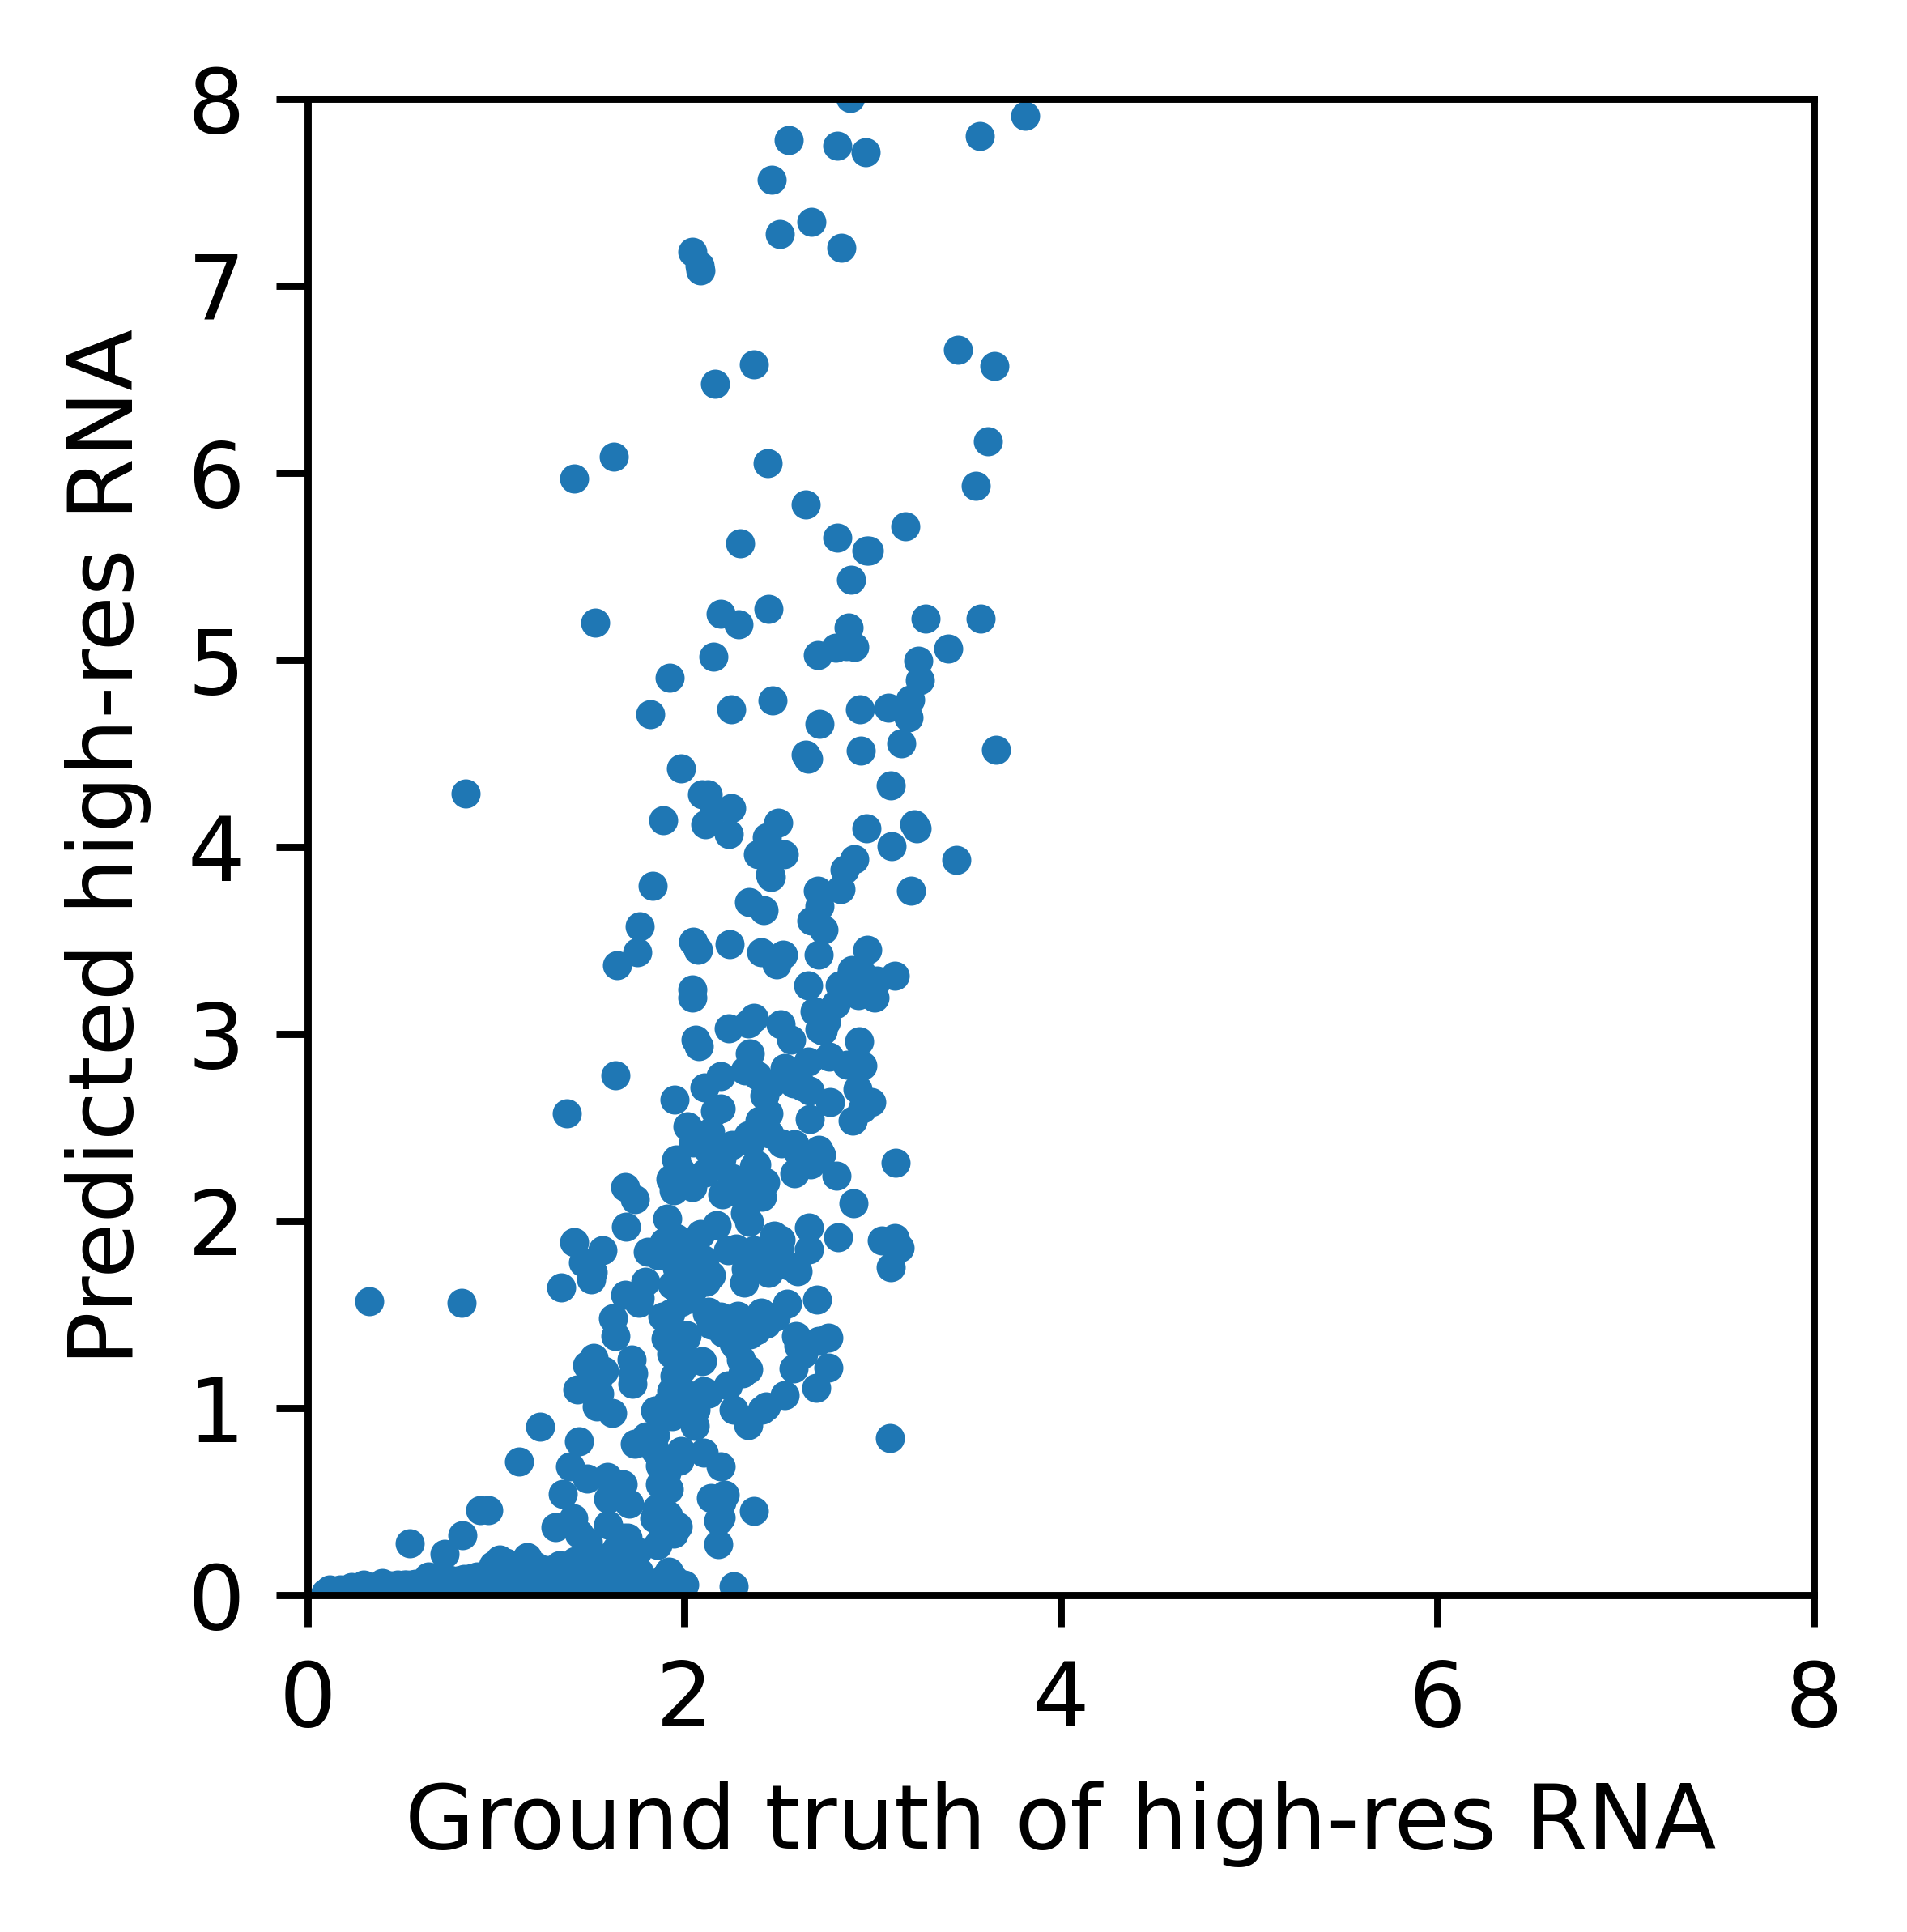

In [25]:
plt.subplots(1,1,figsize=(3,3),dpi=800)
plt.scatter(generated_expr.mean(axis=0),
            visium_adata_all.X.mean(axis=0),
            s=5
            
           )
plt.xlim([0,8])
plt.ylim([0,8])
plt.xlabel('Ground truth of high-res RNA')
plt.ylabel('Predicted high-res RNA')
        

(0.0, 8.0)

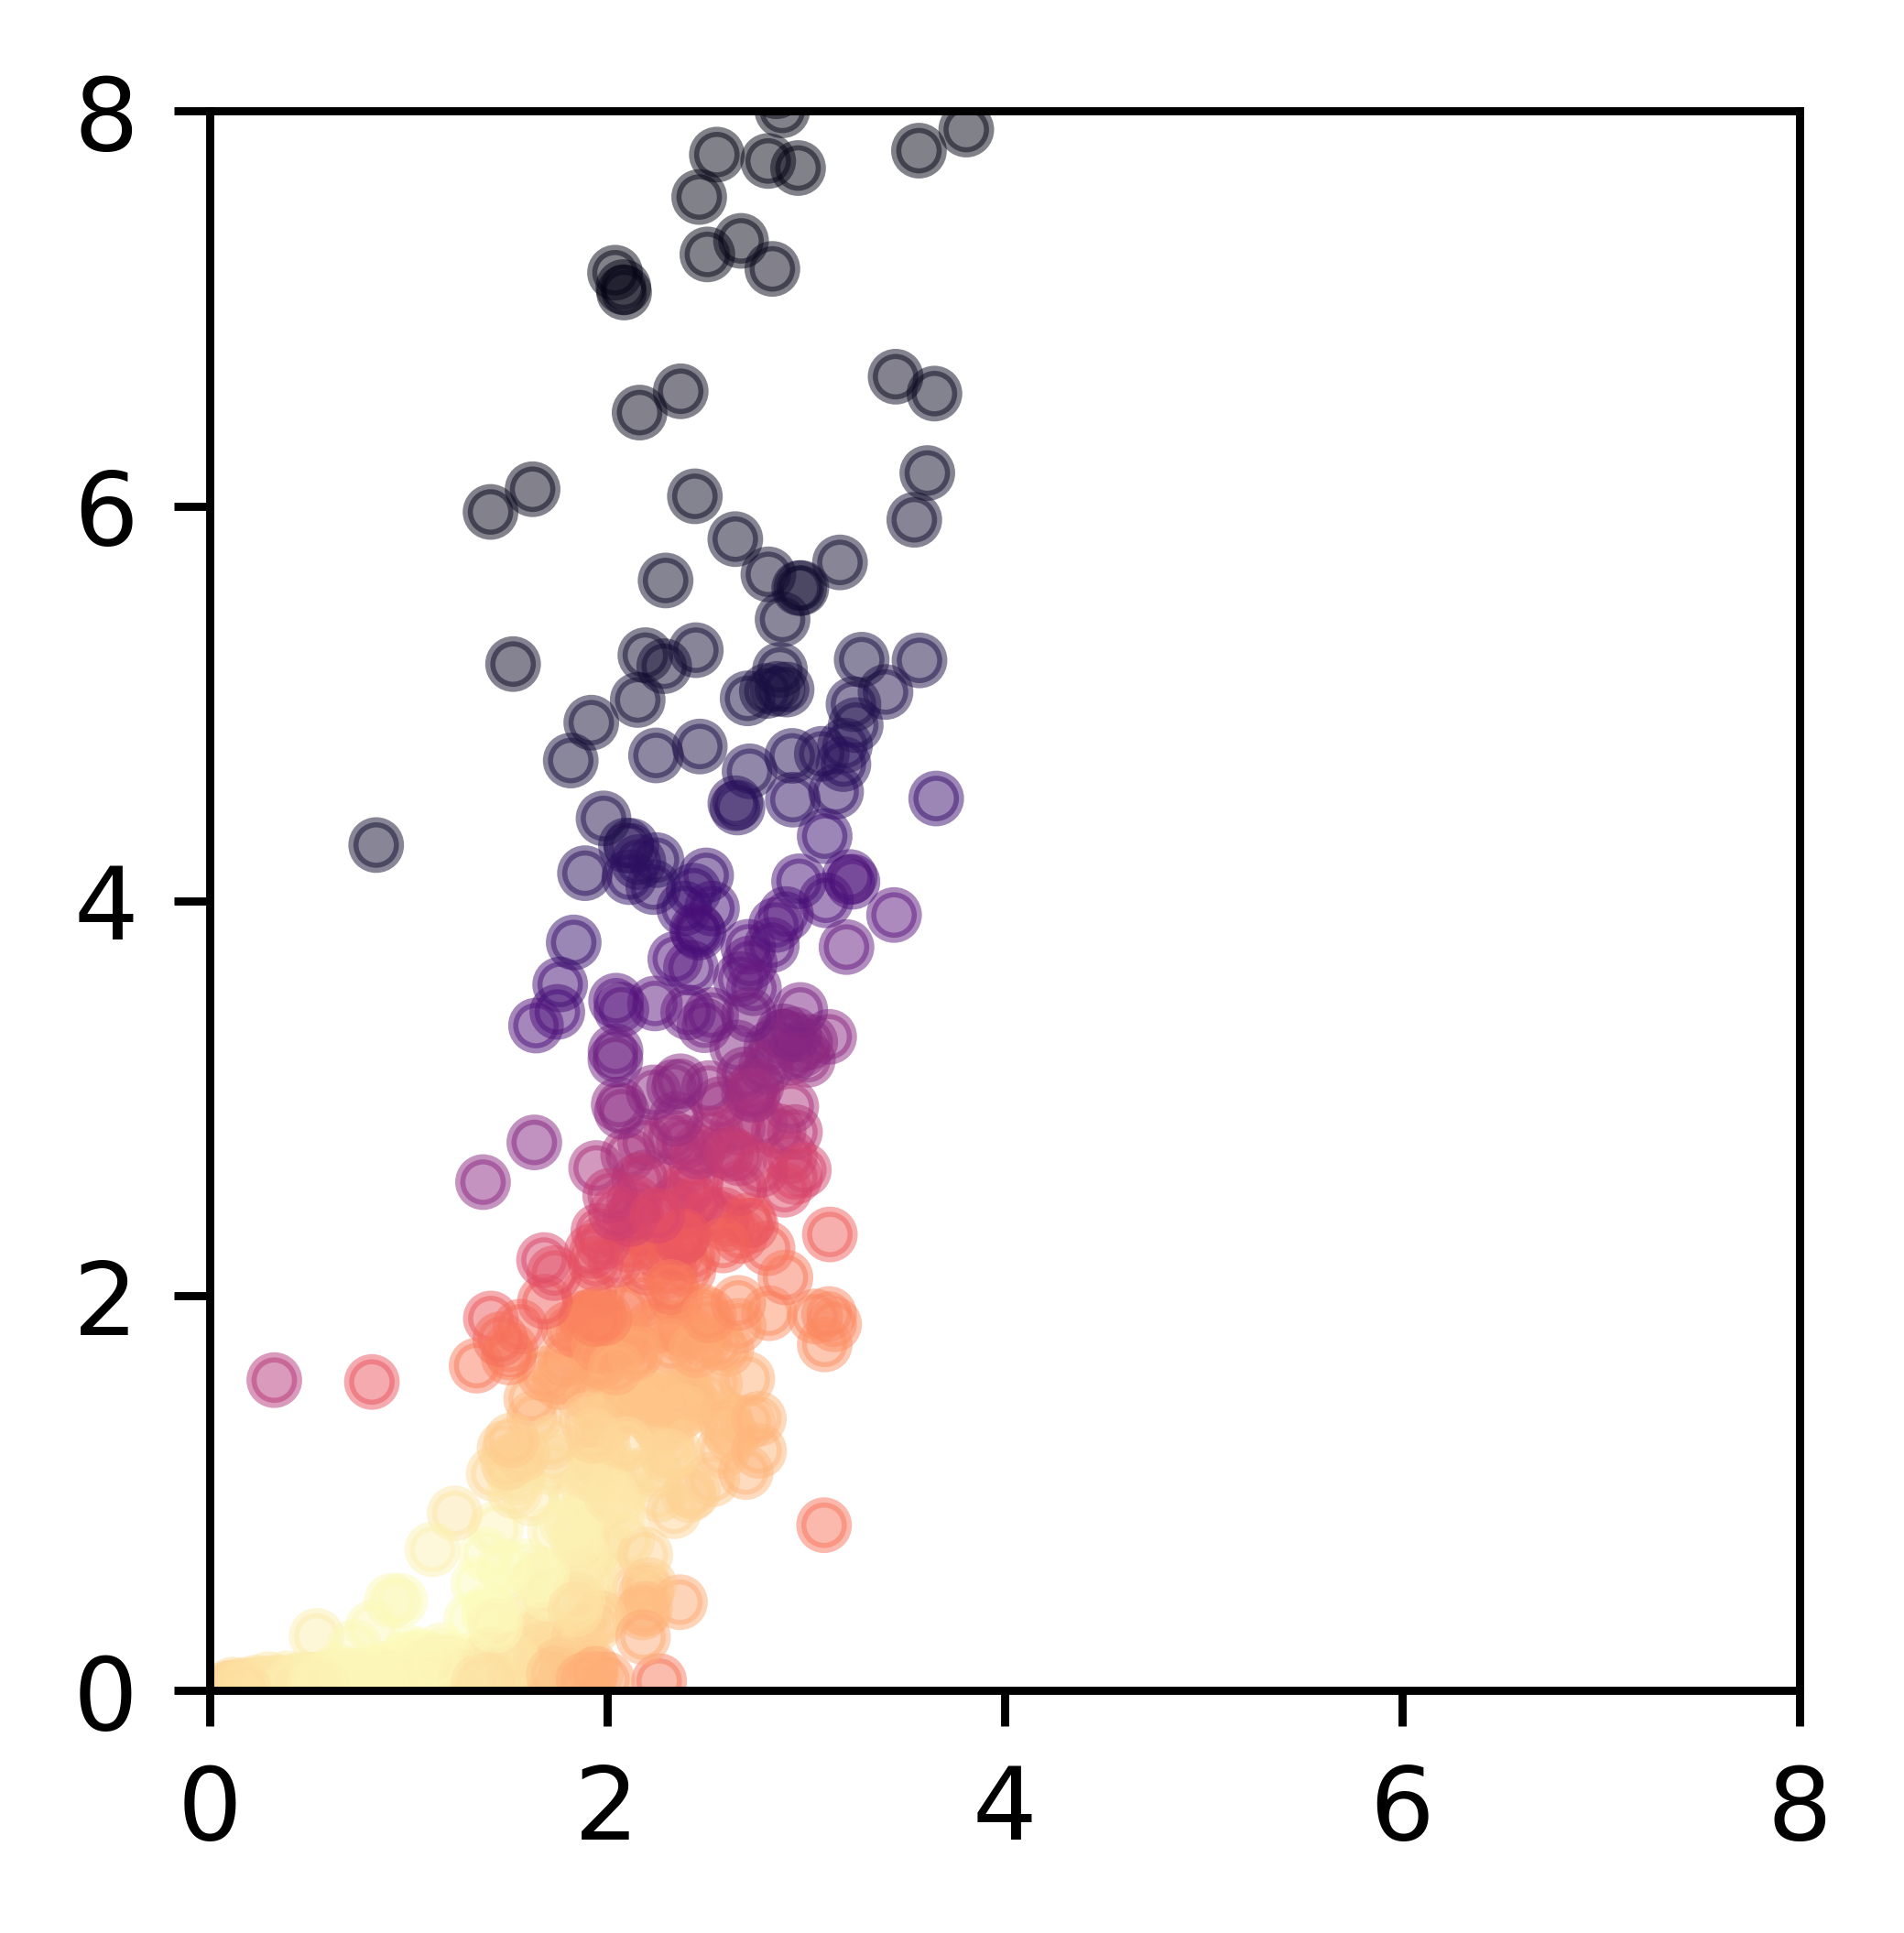

In [29]:
from scipy.stats import gaussian_kde
df_true_sample = pd.DataFrame(generated_expr.mean(axis=0))
df_pred_sample = pd.DataFrame(visium_adata_all.X.mean(axis=0))

plt.figure(figsize=(2.8,2.8),dpi=800)
ax = plt.gca()

xx = df_true_sample.T.to_numpy().flatten()
yy = df_pred_sample.T.to_numpy().flatten()


for gene in df_true_sample.columns:
    try:
        gene_true = df_true_sample[gene].values
        gene_pred = df_pred_sample[gene].values
        gexp_stacked = np.vstack([df_true_sample[gene].values, df_pred_sample[gene].values])

        z = gaussian_kde(gexp_stacked)(gexp_stacked)
        ax.scatter(gene_true, gene_pred, c=z, s=20, alpha=0.5,cmap='magma')
    except np.linalg.LinAlgError as e:
        pass
plt.xlim([0,8])
plt.ylim([0,8])

In [70]:
concat_ =anndata.AnnData(np.concatenate([adata_model_gener_reindexed.obsm['generated_expr']],axis=1))
sc.pp.normalize_total(concat_)
sc.pp.log1p(concat_)
sc.pp.pca(concat_)
sc.pp.neighbors(concat_,n_neighbors=100)
sc.tl.umap(concat_,min_dist=1)
sc.tl.leiden(concat_,resolution=2)

adata_model_gener_reindexed.obsm['sc_inte_umap'] = concat_.obsm['X_umap']


In [71]:
adata_model_gener_reindexed.obs['sc_leiden'] =  np.array(concat_.obs['leiden'])

10
6
4
3
5
11
1
8
0
7
2
9
13


Text(0, 0.5, '')

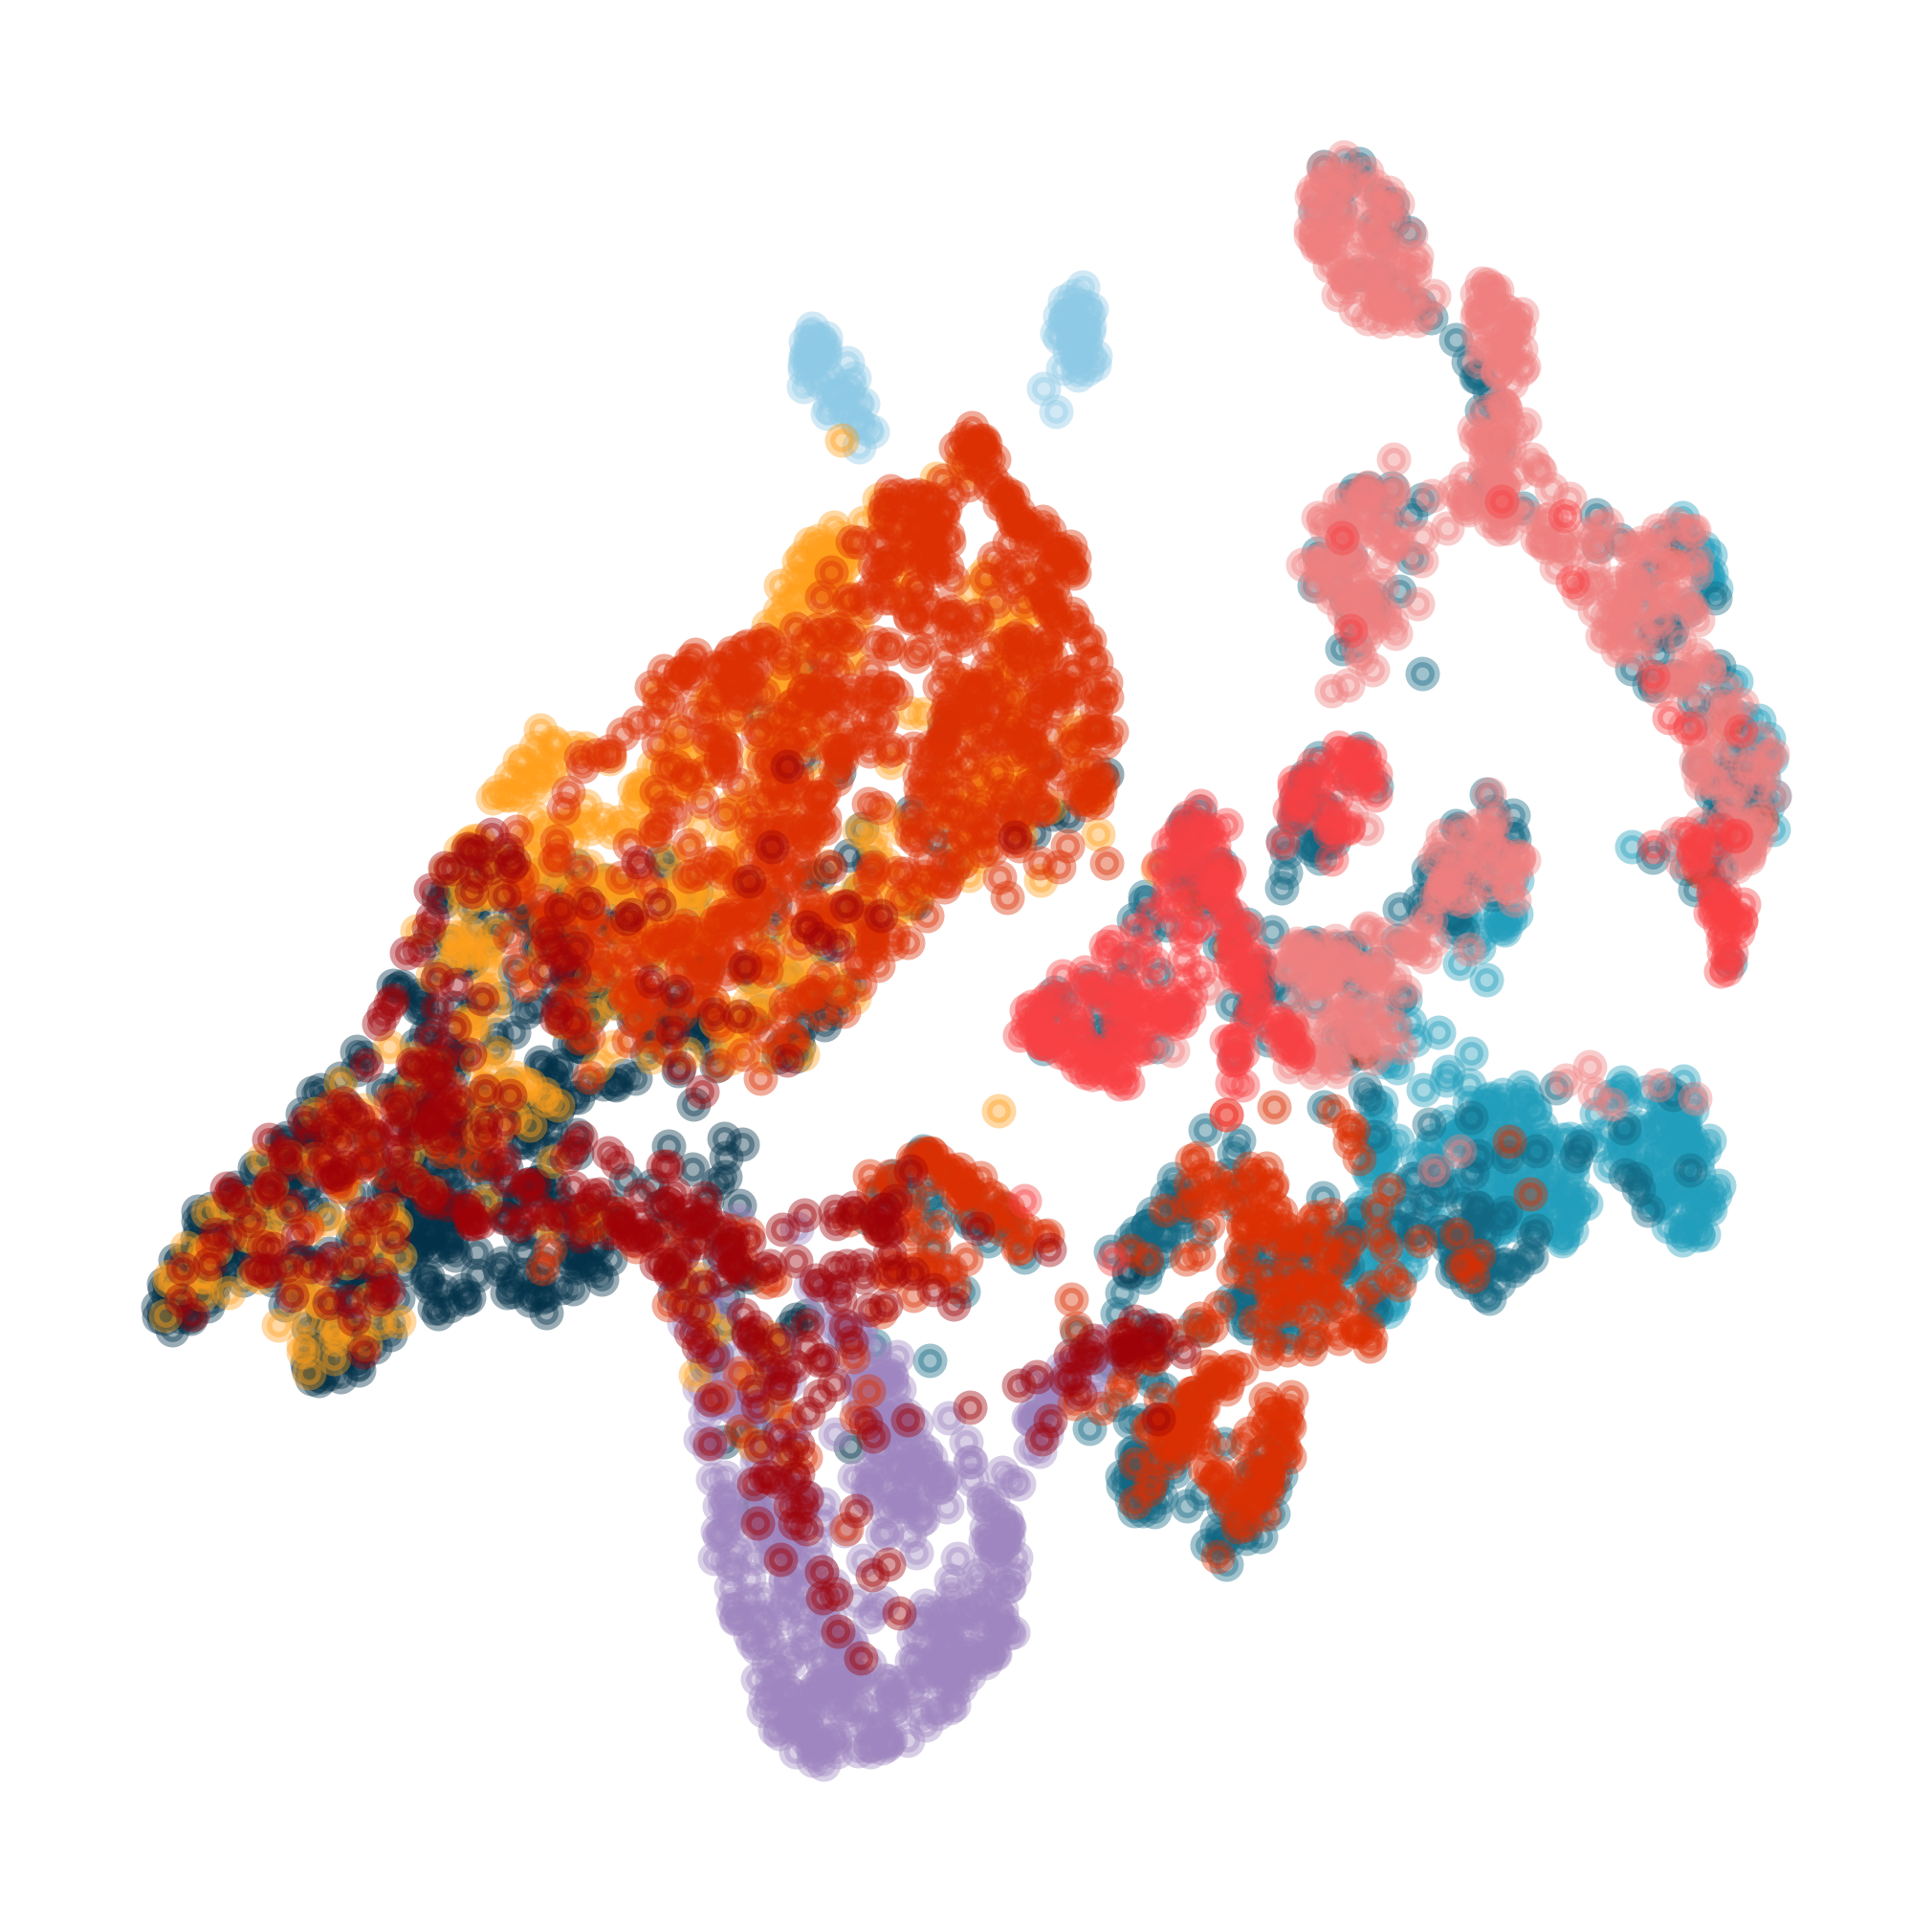

In [73]:
color_list = [
'#8ecae6',
'#219ebc',
'#126782',
'#023047',
'#9f86c0',                                   
'#d4e09b',
    
'#ff9f1c',
'#dc2f02',

'#dc2f02',
'#9d0208',
'#f08080',
'#f94144',
                    '#f3722c',
                    '#f8961e',
                    '#f9c74f',
                    '#90be6d',
                    '#43aa8b',
                    '#577590',  
                    '#226CE0',
                    '#534B62'
]
plt.subplots(1,1,figsize= (3,3),dpi=800)
for j,i in enumerate(codex_adata_cropped.obs['cell_type'].unique()):
    print(i)
    plt.scatter(adata_model_gener_reindexed.obsm['sc_inte_umap'][adata_model_gener_reindexed.obs['leiden']==str(i),0],
                adata_model_gener_reindexed.obsm['sc_inte_umap'][adata_model_gener_reindexed.obs['leiden']==str(i),1],
                s=5,
                alpha = 0.4,
                color = color_list[j]
               )
#plt.legend(adata_model_gener_reindexed.obs['cluster'].unique(),bbox_to_anchor=(1.01,0.8))
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

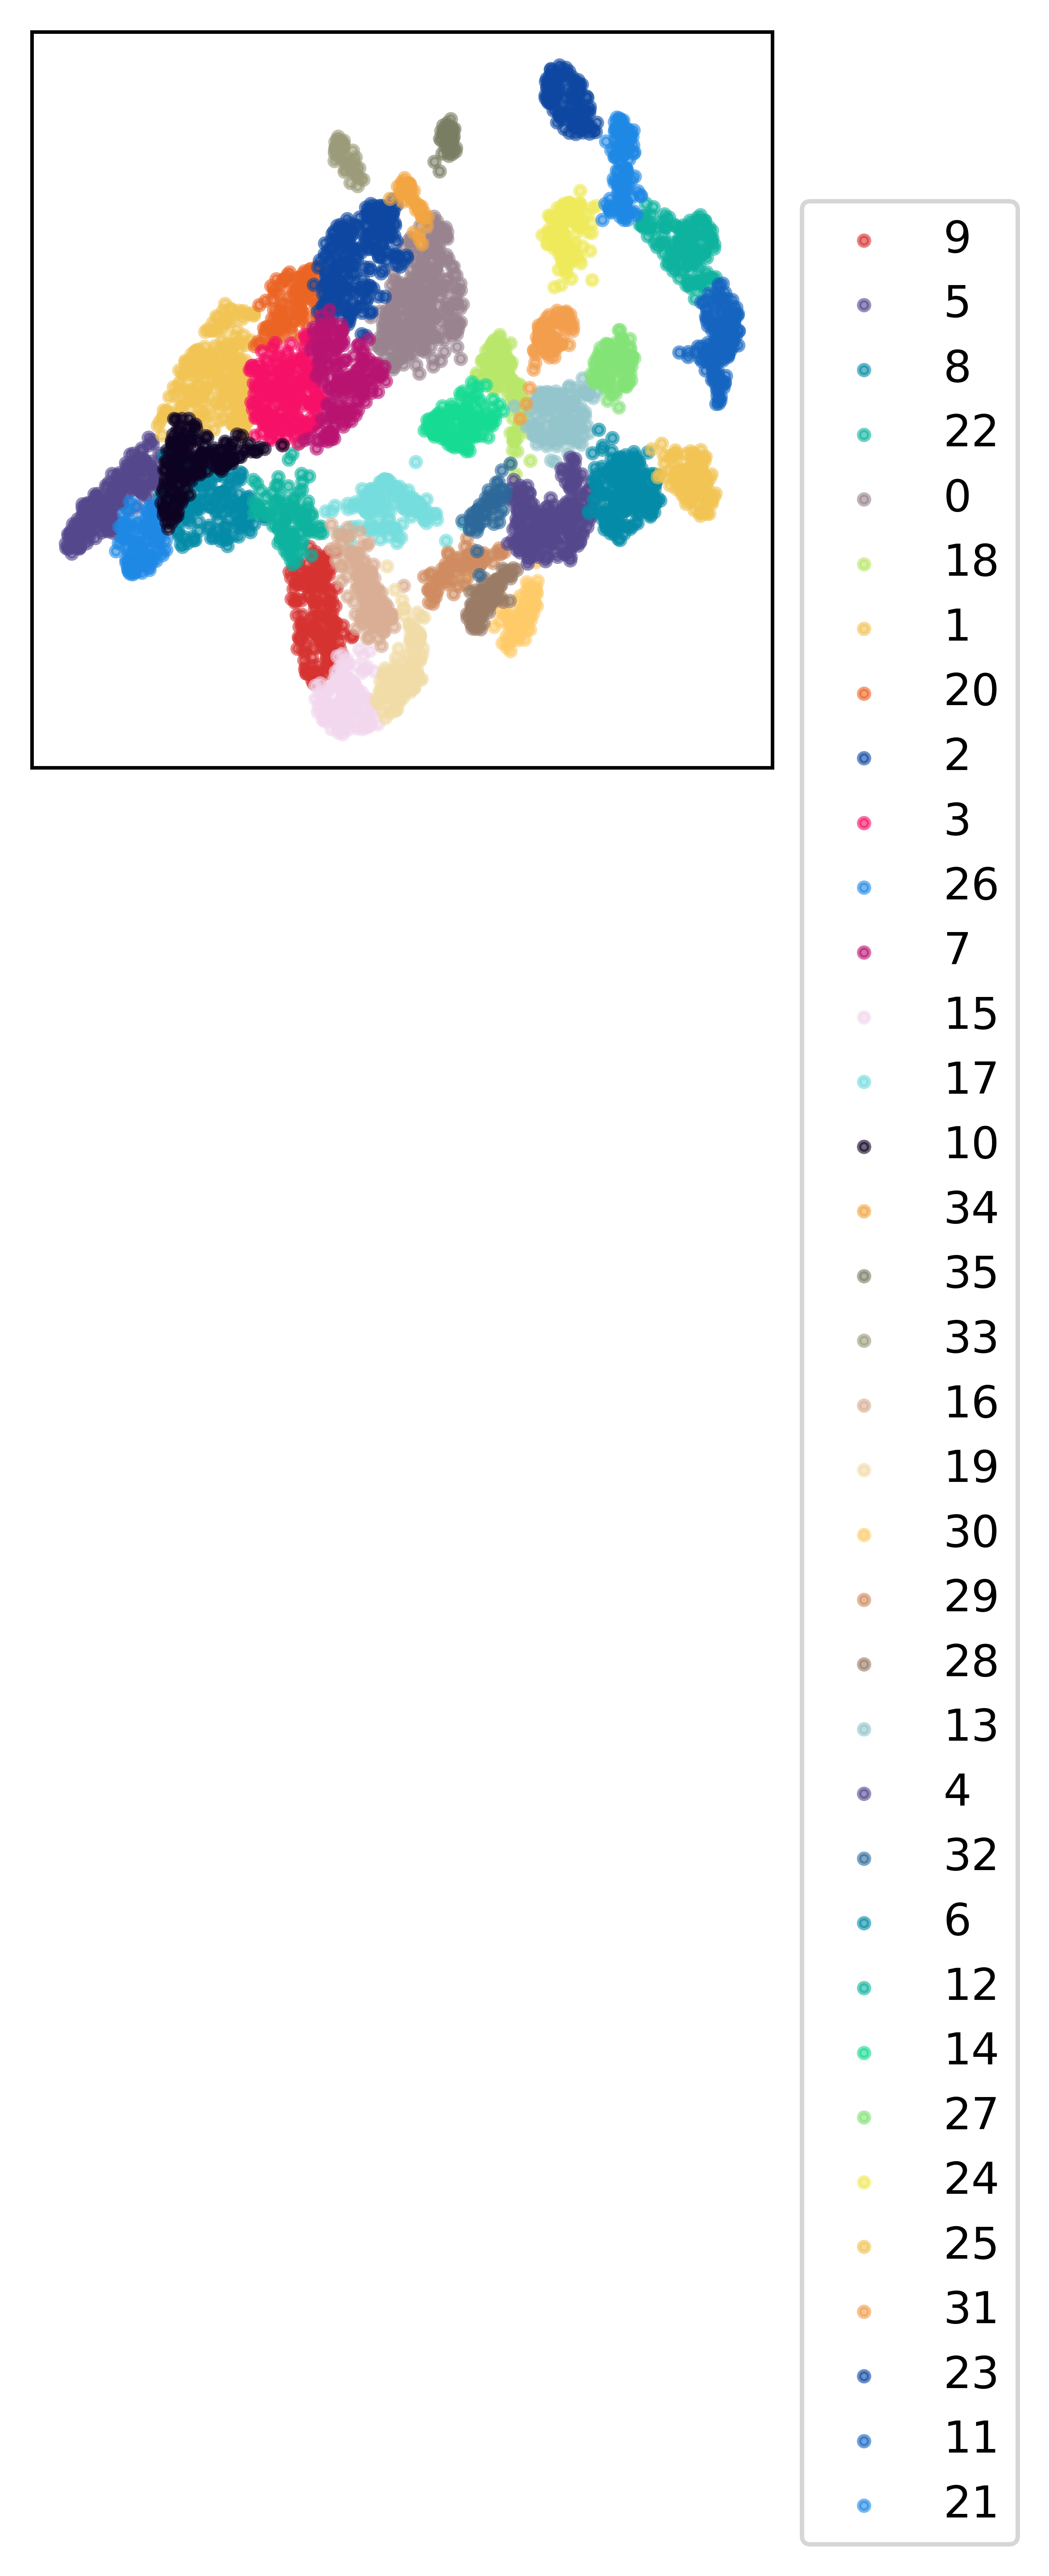

In [74]:

color_list = [
    '#D63230','#54478c', '#048ba8', '#0db39e', '#98838F',

              '#b9e769', 

              '#f1c453', 

              '#EB6424',
              '#0d47a1', 
              '#F61067',
              '#1e88e5',
             '#B91372',
              '#F2D7EE',
              '#75DDDD',
              '#0D0221',
             '#F2A541',
    '#797d62',
                '#9b9b7a',
                '#d9ae94',
                '#f1dca7',
                '#ffcb69',
                '#d08c60',
                '#997b66',
                '#94C5CC',
    
    
    '#54478c', '#2c699a', 
    '#048ba8', '#0db39e', '#16db93',
              '#83e377', 
    '#efea5a', '#f1c453', '#f29e4c',
              '#0d47a1', '#1565c0', '#1e88e5', 
    '#42a5f5', '#90caf9',
              '#bbdefb','#D63230',

              '#b9e769', 

              '#f1c453', 

              '#EB6424',
              '#0d47a1', 
              '#F61067',
              '#1e88e5',
             '#B91372',
              '#F2D7EE',
              '#75DDDD',
              '#0D0221',
             '#F2A541'
             ]
plt.subplots(1,1,figsize= (3,3),dpi=800)
for j,i in enumerate(adata_model_gener_reindexed.obs['sc_leiden'].unique()):
    plt.scatter(adata_model_gener_reindexed.obsm['sc_inte_umap'][adata_model_gener_reindexed.obs['sc_leiden']==i,0],
                adata_model_gener_reindexed.obsm['sc_inte_umap'][adata_model_gener_reindexed.obs['sc_leiden']==i,1],
                s=5,
                alpha = 0.6,
                color = color_list[j]
               )
plt.legend(adata_model_gener_reindexed.obs['sc_leiden'].unique(),bbox_to_anchor=(1.01,0.8))
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

In [78]:
generated_expr_adata = anndata.AnnData(adata_model_gener_reindexed.obsm['generated_expr'])
generated_expr_adata.var_names = visium_adata_cropped.var_names
generated_expr_adata.obs_names = codex_adata_cropped.obs_names


In [79]:
generated_expr_adata.var_names

Index(['A4GNT', 'ABCG2', 'ABHD15', 'ABHD18', 'AC004593.3', 'AC011005.1',
       'AC072022.2', 'AC099489.1', 'AC233723.1', 'ACAA1',
       ...
       'ZNF792', 'ZNF823', 'ZNHIT2', 'ZPBP2', 'ZSCAN18', 'ZSCAN25', 'ZSCAN30',
       'ZSWIM2', 'ZSWIM4', 'ZYG11B'],
      dtype='object', length=1046)

Text(0, 0.5, '')

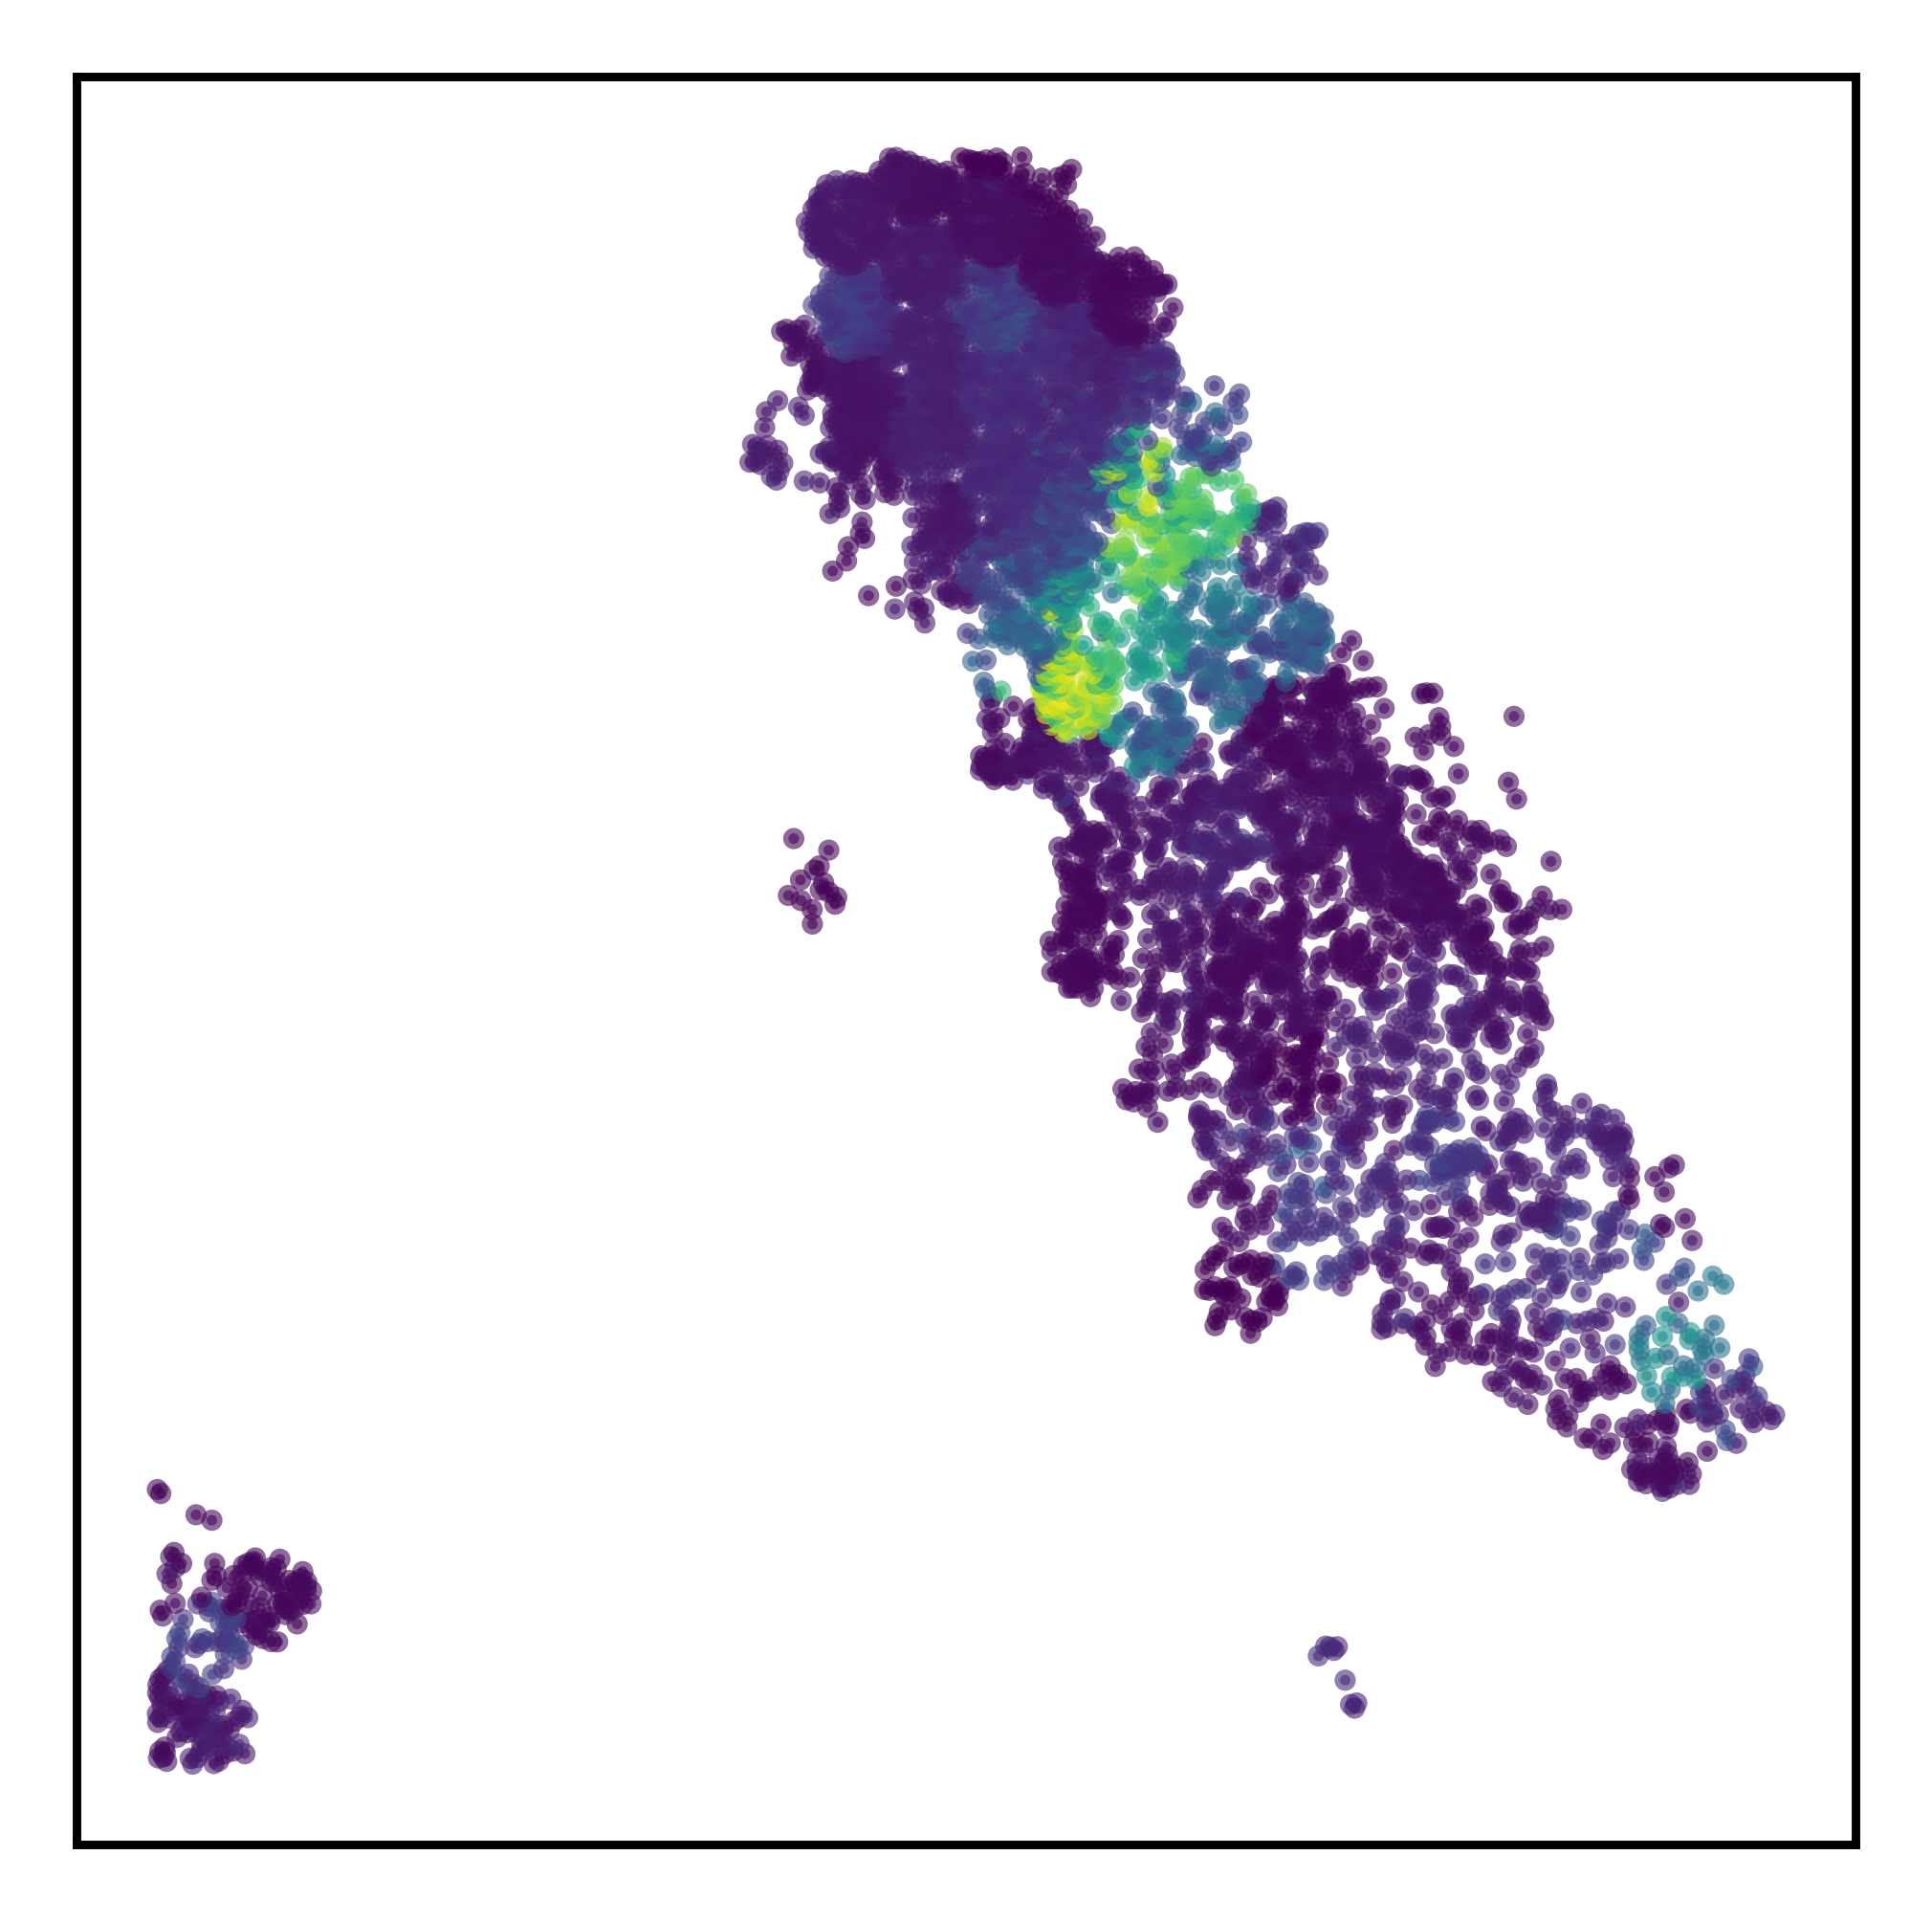

In [80]:
plt.subplots(1,1,figsize= (3,3),dpi=800)
plt.scatter(adata_model_gener_reindexed.obsm['spatial'][:,0],
            adata_model_gener_reindexed.obsm['spatial'][:,1],
                s=1,
                alpha = 0.6,
                c = generated_expr_adata[:,'PECAM1'].to_df().values,
               )
#plt.legend(adata_model_gener_reindexed.obs['sc_leiden'].unique(),bbox_to_anchor=(1.01,0.8))
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')